In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from ddpm.diffusion import Diffusion
from models import UNet2D
from dataset import ContourDataset
import pandas as pd
import glob
import os

In [3]:
data_csv = '/hot/Yi-Kuan/Fibrosis/label.csv'
data_dir = '/hot/Yi-Kuan/Fibrosis/'
ckpt_dir = '/hot/Yi-Kuan/Fibrosis/trained_models/trained_models/'
batch_size = 20
n_batches = 5
downsample_size = (128, 128)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
dataset = ContourDataset(data_csv, data_dir, istransform=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

batches = []
for _ in range(n_batches):
    imgs, ctrs = next(iter(dataloader))
    # Downsample for speed
    imgs_small = F.interpolate(imgs, size=downsample_size, mode='bilinear', align_corners=False)
    ctrs_small = F.interpolate(ctrs, size=downsample_size, mode='nearest')
    batches.append((imgs_small.to(device), ctrs_small.to(device)))

In [13]:
results = []
ckpt_paths = sorted(glob.glob(os.path.join(ckpt_dir, '*.pt')))
diffusion = Diffusion(
    noise_step=1000,  # or whatever you used
    beta_start=1e-4,
    beta_end=0.02,
    img_size=downsample_size[0],  # assuming square
    device=device
)
for ckpt_path in ckpt_paths:
    # Load and prepare model
    base_model = UNet2D(
        img_size=256,      # or the correct size
        in_channels=2,     # or the correct number
        out_channels=1     # or the correct number
    ).to(device)
    ck = torch.load(ckpt_path, map_location=device)
    print(ck.keys())
    base_model.load_state_dict(ck['model'])
    base_model.eval()

    # JIT trace once using first batch
    imgs0, ctrs0 = batches[0]
    t0 = torch.zeros(imgs0.size(0), dtype=torch.long, device=device)
    traced_model = torch.jit.trace(
        base_model,
        (torch.cat([imgs0, ctrs0], dim=1), t0)
    )

    mses = []
    ious = []
    with torch.no_grad():
        for imgs_batch, ctrs_batch in batches:
            # Generate samples using the diffusion process
            # If your model is conditioned, pass ctrs_batch as condition
            samples = diffusion.sample(base_model, imgs_batch.size(0), condition=ctrs_batch)
            # MSE
            mse_val = F.mse_loss(samples, ctrs_batch).item()
            mses.append(mse_val)
            # IoU
            pred_bin = (samples > 0.5).float()
            intersection = (pred_bin * ctrs_batch).sum(dim=[1,2,3])
            union = ((pred_bin + ctrs_batch) > 0).float().sum(dim=[1,2,3])
            iou_val = (intersection / union).mean().item()
            ious.append(iou_val)

    results.append({
        'checkpoint': os.path.basename(ckpt_path),
        'mse_mean': sum(mses) / len(mses),
        'iou_mean': sum(ious) / len(ious)
    })

/tmp/ipykernel_150584/3956466447.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(ckpt_path, map_location=device)


dict_keys(['epoch', 'model', 'optimizer', 'loss'])


RuntimeError: Error(s) in loading state_dict for UNet2D:
	Missing key(s) in state_dict: "time_mlp.1.weight", "time_mlp.1.bias", "time_mlp.3.weight", "time_mlp.3.bias", "down4.maxpool_conv.1.double_conv.0.weight", "down4.maxpool_conv.1.double_conv.1.weight", "down4.maxpool_conv.1.double_conv.1.bias", "down4.maxpool_conv.1.double_conv.1.running_mean", "down4.maxpool_conv.1.double_conv.1.running_var", "down4.maxpool_conv.1.double_conv.3.weight", "down4.maxpool_conv.1.double_conv.4.weight", "down4.maxpool_conv.1.double_conv.4.bias", "down4.maxpool_conv.1.double_conv.4.running_mean", "down4.maxpool_conv.1.double_conv.4.running_var", "attn1.mha.in_proj_weight", "attn1.mha.in_proj_bias", "attn1.mha.out_proj.weight", "attn1.mha.out_proj.bias", "attn1.ln.weight", "attn1.ln.bias", "attn1.ff_self.0.weight", "attn1.ff_self.0.bias", "attn1.ff_self.1.weight", "attn1.ff_self.1.bias", "attn1.ff_self.3.weight", "attn1.ff_self.3.bias", "attn2.mha.in_proj_weight", "attn2.mha.in_proj_bias", "attn2.mha.out_proj.weight", "attn2.mha.out_proj.bias", "attn2.ln.weight", "attn2.ln.bias", "attn2.ff_self.0.weight", "attn2.ff_self.0.bias", "attn2.ff_self.1.weight", "attn2.ff_self.1.bias", "attn2.ff_self.3.weight", "attn2.ff_self.3.bias", "attn3.mha.in_proj_weight", "attn3.mha.in_proj_bias", "attn3.mha.out_proj.weight", "attn3.mha.out_proj.bias", "attn3.ln.weight", "attn3.ln.bias", "attn3.ff_self.0.weight", "attn3.ff_self.0.bias", "attn3.ff_self.1.weight", "attn3.ff_self.1.bias", "attn3.ff_self.3.weight", "attn3.ff_self.3.bias", "up1.conv.double_conv.0.weight", "up1.conv.double_conv.1.weight", "up1.conv.double_conv.1.bias", "up1.conv.double_conv.1.running_mean", "up1.conv.double_conv.1.running_var", "up1.conv.double_conv.3.weight", "up1.conv.double_conv.4.weight", "up1.conv.double_conv.4.bias", "up1.conv.double_conv.4.running_mean", "up1.conv.double_conv.4.running_var", "up2.conv.double_conv.0.weight", "up2.conv.double_conv.1.weight", "up2.conv.double_conv.1.bias", "up2.conv.double_conv.1.running_mean", "up2.conv.double_conv.1.running_var", "up2.conv.double_conv.3.weight", "up2.conv.double_conv.4.weight", "up2.conv.double_conv.4.bias", "up2.conv.double_conv.4.running_mean", "up2.conv.double_conv.4.running_var", "up3.conv.double_conv.0.weight", "up3.conv.double_conv.1.weight", "up3.conv.double_conv.1.bias", "up3.conv.double_conv.1.running_mean", "up3.conv.double_conv.1.running_var", "up3.conv.double_conv.3.weight", "up3.conv.double_conv.4.weight", "up3.conv.double_conv.4.bias", "up3.conv.double_conv.4.running_mean", "up3.conv.double_conv.4.running_var", "up4.up.weight", "up4.up.bias", "up4.conv.double_conv.0.weight", "up4.conv.double_conv.1.weight", "up4.conv.double_conv.1.bias", "up4.conv.double_conv.1.running_mean", "up4.conv.double_conv.1.running_var", "up4.conv.double_conv.3.weight", "up4.conv.double_conv.4.weight", "up4.conv.double_conv.4.bias", "up4.conv.double_conv.4.running_mean", "up4.conv.double_conv.4.running_var", "outc.conv.weight", "outc.conv.bias". 
	Unexpected key(s) in state_dict: "att1.channel_attention.1.weight", "att1.channel_attention.1.bias", "att1.channel_attention.3.weight", "att1.channel_attention.3.bias", "att1.spatial_attention.0.weight", "att1.spatial_attention.0.bias", "att2.channel_attention.1.weight", "att2.channel_attention.1.bias", "att2.channel_attention.3.weight", "att2.channel_attention.3.bias", "att2.spatial_attention.0.weight", "att2.spatial_attention.0.bias", "att3.channel_attention.1.weight", "att3.channel_attention.1.bias", "att3.channel_attention.3.weight", "att3.channel_attention.3.bias", "att3.spatial_attention.0.weight", "att3.spatial_attention.0.bias", "bot1.double_conv.0.weight", "bot1.double_conv.1.weight", "bot1.double_conv.1.bias", "bot1.double_conv.1.running_mean", "bot1.double_conv.1.running_var", "bot1.double_conv.1.num_batches_tracked", "bot1.double_conv.3.weight", "bot1.double_conv.4.weight", "bot1.double_conv.4.bias", "bot1.double_conv.4.running_mean", "bot1.double_conv.4.running_var", "bot1.double_conv.4.num_batches_tracked", "bot2.double_conv.0.weight", "bot2.double_conv.1.weight", "bot2.double_conv.1.bias", "bot2.double_conv.1.running_mean", "bot2.double_conv.1.running_var", "bot2.double_conv.1.num_batches_tracked", "bot2.double_conv.3.weight", "bot2.double_conv.4.weight", "bot2.double_conv.4.bias", "bot2.double_conv.4.running_mean", "bot2.double_conv.4.running_var", "bot2.double_conv.4.num_batches_tracked", "bot3.double_conv.0.weight", "bot3.double_conv.1.weight", "bot3.double_conv.1.bias", "bot3.double_conv.1.running_mean", "bot3.double_conv.1.running_var", "bot3.double_conv.1.num_batches_tracked", "bot3.double_conv.3.weight", "bot3.double_conv.4.weight", "bot3.double_conv.4.bias", "bot3.double_conv.4.running_mean", "bot3.double_conv.4.running_var", "bot3.double_conv.4.num_batches_tracked", "att4.channel_attention.1.weight", "att4.channel_attention.1.bias", "att4.channel_attention.3.weight", "att4.channel_attention.3.bias", "att4.spatial_attention.0.weight", "att4.spatial_attention.0.bias", "att5.channel_attention.1.weight", "att5.channel_attention.1.bias", "att5.channel_attention.3.weight", "att5.channel_attention.3.bias", "att5.spatial_attention.0.weight", "att5.spatial_attention.0.bias", "att6.channel_attention.1.weight", "att6.channel_attention.1.bias", "att6.channel_attention.3.weight", "att6.channel_attention.3.bias", "att6.spatial_attention.0.weight", "att6.spatial_attention.0.bias", "down1.emb_layer.1.weight", "down1.emb_layer.1.bias", "down1.maxpool_conv.2.double_conv.0.weight", "down1.maxpool_conv.2.double_conv.1.weight", "down1.maxpool_conv.2.double_conv.1.bias", "down1.maxpool_conv.2.double_conv.1.running_mean", "down1.maxpool_conv.2.double_conv.1.running_var", "down1.maxpool_conv.2.double_conv.1.num_batches_tracked", "down1.maxpool_conv.2.double_conv.3.weight", "down1.maxpool_conv.2.double_conv.4.weight", "down1.maxpool_conv.2.double_conv.4.bias", "down1.maxpool_conv.2.double_conv.4.running_mean", "down1.maxpool_conv.2.double_conv.4.running_var", "down1.maxpool_conv.2.double_conv.4.num_batches_tracked", "down2.emb_layer.1.weight", "down2.emb_layer.1.bias", "down2.maxpool_conv.2.double_conv.0.weight", "down2.maxpool_conv.2.double_conv.1.weight", "down2.maxpool_conv.2.double_conv.1.bias", "down2.maxpool_conv.2.double_conv.1.running_mean", "down2.maxpool_conv.2.double_conv.1.running_var", "down2.maxpool_conv.2.double_conv.1.num_batches_tracked", "down2.maxpool_conv.2.double_conv.3.weight", "down2.maxpool_conv.2.double_conv.4.weight", "down2.maxpool_conv.2.double_conv.4.bias", "down2.maxpool_conv.2.double_conv.4.running_mean", "down2.maxpool_conv.2.double_conv.4.running_var", "down2.maxpool_conv.2.double_conv.4.num_batches_tracked", "down3.emb_layer.1.weight", "down3.emb_layer.1.bias", "down3.maxpool_conv.2.double_conv.0.weight", "down3.maxpool_conv.2.double_conv.1.weight", "down3.maxpool_conv.2.double_conv.1.bias", "down3.maxpool_conv.2.double_conv.1.running_mean", "down3.maxpool_conv.2.double_conv.1.running_var", "down3.maxpool_conv.2.double_conv.1.num_batches_tracked", "down3.maxpool_conv.2.double_conv.3.weight", "down3.maxpool_conv.2.double_conv.4.weight", "down3.maxpool_conv.2.double_conv.4.bias", "down3.maxpool_conv.2.double_conv.4.running_mean", "down3.maxpool_conv.2.double_conv.4.running_var", "down3.maxpool_conv.2.double_conv.4.num_batches_tracked", "up1.emb_layer.1.weight", "up1.emb_layer.1.bias", "up1.conv.0.double_conv.0.weight", "up1.conv.0.double_conv.1.weight", "up1.conv.0.double_conv.1.bias", "up1.conv.0.double_conv.1.running_mean", "up1.conv.0.double_conv.1.running_var", "up1.conv.0.double_conv.1.num_batches_tracked", "up1.conv.0.double_conv.3.weight", "up1.conv.0.double_conv.4.weight", "up1.conv.0.double_conv.4.bias", "up1.conv.0.double_conv.4.running_mean", "up1.conv.0.double_conv.4.running_var", "up1.conv.0.double_conv.4.num_batches_tracked", "up1.conv.1.double_conv.0.weight", "up1.conv.1.double_conv.1.weight", "up1.conv.1.double_conv.1.bias", "up1.conv.1.double_conv.1.running_mean", "up1.conv.1.double_conv.1.running_var", "up1.conv.1.double_conv.1.num_batches_tracked", "up1.conv.1.double_conv.3.weight", "up1.conv.1.double_conv.4.weight", "up1.conv.1.double_conv.4.bias", "up1.conv.1.double_conv.4.running_mean", "up1.conv.1.double_conv.4.running_var", "up1.conv.1.double_conv.4.num_batches_tracked", "up2.emb_layer.1.weight", "up2.emb_layer.1.bias", "up2.conv.0.double_conv.0.weight", "up2.conv.0.double_conv.1.weight", "up2.conv.0.double_conv.1.bias", "up2.conv.0.double_conv.1.running_mean", "up2.conv.0.double_conv.1.running_var", "up2.conv.0.double_conv.1.num_batches_tracked", "up2.conv.0.double_conv.3.weight", "up2.conv.0.double_conv.4.weight", "up2.conv.0.double_conv.4.bias", "up2.conv.0.double_conv.4.running_mean", "up2.conv.0.double_conv.4.running_var", "up2.conv.0.double_conv.4.num_batches_tracked", "up2.conv.1.double_conv.0.weight", "up2.conv.1.double_conv.1.weight", "up2.conv.1.double_conv.1.bias", "up2.conv.1.double_conv.1.running_mean", "up2.conv.1.double_conv.1.running_var", "up2.conv.1.double_conv.1.num_batches_tracked", "up2.conv.1.double_conv.3.weight", "up2.conv.1.double_conv.4.weight", "up2.conv.1.double_conv.4.bias", "up2.conv.1.double_conv.4.running_mean", "up2.conv.1.double_conv.4.running_var", "up2.conv.1.double_conv.4.num_batches_tracked", "up3.emb_layer.1.weight", "up3.emb_layer.1.bias", "up3.conv.0.double_conv.0.weight", "up3.conv.0.double_conv.1.weight", "up3.conv.0.double_conv.1.bias", "up3.conv.0.double_conv.1.running_mean", "up3.conv.0.double_conv.1.running_var", "up3.conv.0.double_conv.1.num_batches_tracked", "up3.conv.0.double_conv.3.weight", "up3.conv.0.double_conv.4.weight", "up3.conv.0.double_conv.4.bias", "up3.conv.0.double_conv.4.running_mean", "up3.conv.0.double_conv.4.running_var", "up3.conv.0.double_conv.4.num_batches_tracked", "up3.conv.1.double_conv.0.weight", "up3.conv.1.double_conv.1.weight", "up3.conv.1.double_conv.1.bias", "up3.conv.1.double_conv.1.running_mean", "up3.conv.1.double_conv.1.running_var", "up3.conv.1.double_conv.1.num_batches_tracked", "up3.conv.1.double_conv.3.weight", "up3.conv.1.double_conv.4.weight", "up3.conv.1.double_conv.4.bias", "up3.conv.1.double_conv.4.running_mean", "up3.conv.1.double_conv.4.running_var", "up3.conv.1.double_conv.4.num_batches_tracked", "outc.weight", "outc.bias". 
	size mismatch for down1.maxpool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for down1.maxpool_conv.1.double_conv.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.maxpool_conv.1.double_conv.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.maxpool_conv.1.double_conv.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.maxpool_conv.1.double_conv.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.maxpool_conv.1.double_conv.3.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for down1.maxpool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.maxpool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.maxpool_conv.1.double_conv.4.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down1.maxpool_conv.1.double_conv.4.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for down2.maxpool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for down2.maxpool_conv.1.double_conv.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.maxpool_conv.1.double_conv.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.maxpool_conv.1.double_conv.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.maxpool_conv.1.double_conv.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.maxpool_conv.1.double_conv.3.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for down2.maxpool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.maxpool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.maxpool_conv.1.double_conv.4.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down2.maxpool_conv.1.double_conv.4.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for down3.maxpool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for down3.maxpool_conv.1.double_conv.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down3.maxpool_conv.1.double_conv.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down3.maxpool_conv.1.double_conv.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down3.maxpool_conv.1.double_conv.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down3.maxpool_conv.1.double_conv.3.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for down3.maxpool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down3.maxpool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down3.maxpool_conv.1.double_conv.4.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for down3.maxpool_conv.1.double_conv.4.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up1.up.weight: copying a param with shape torch.Size([256, 256, 2, 2]) from checkpoint, the shape in current model is torch.Size([1024, 512, 2, 2]).
	size mismatch for up1.up.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for up2.up.weight: copying a param with shape torch.Size([128, 128, 2, 2]) from checkpoint, the shape in current model is torch.Size([512, 256, 2, 2]).
	size mismatch for up2.up.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up3.up.weight: copying a param with shape torch.Size([64, 64, 2, 2]) from checkpoint, the shape in current model is torch.Size([256, 128, 2, 2]).
	size mismatch for up3.up.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).

In [ ]:
df_results = pd.DataFrame(results).sort_values('mse_mean').reset_index(drop=True)
df_results

,checkpoint,mse_mean,iou_mean
0,model_510.pt,0.186669,0.034461
1,model_330.pt,0.191856,0.048311
2,model_360.pt,0.196441,0.044699
3,model_390.pt,0.199314,0.042039
4,model_780.pt,0.200044,0.039439
5,model_420.pt,0.204142,0.046577
6,model_810.pt,0.205170,0.045727
7,model_720.pt,0.205494,0.035654
8,model_570.pt,0.207128,0.032781
9,model_630.pt,0.217800,0.043386


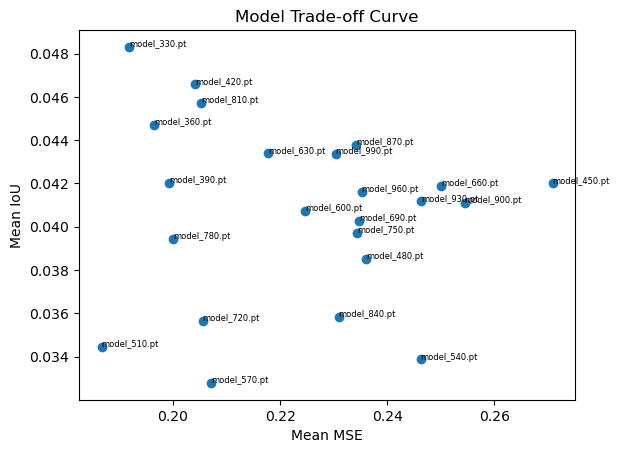

In [14]:
import matplotlib.pyplot as plt

plt.scatter(df_results['mse_mean'], df_results['iou_mean'])
for _, row in df_results.iterrows():
    plt.text(row['mse_mean'], row['iou_mean'], row['checkpoint'], fontsize=6)
plt.xlabel('Mean MSE')
plt.ylabel('Mean IoU')
plt.title('Model Trade-off Curve')
plt.show()